In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

root = os.path.dirname(os.getcwd())
exa_root = '/home/jorgemarpa/data/'

# Metadata

In [2]:
meta = np.load('%s/imgs/PPD/param_arr_gridandfiller123.npy' % (exa_root))
meta = pd.DataFrame(meta, columns=['m_dust', 'Rc', 'f_exp', 'H0', 
                                   'Rin', 'sd_exp', 'a_max', 'inc'],
                    dtype=np.float32)
meta.head()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
0,1.000000e-07,100.0,1.15,5.0,0.1,0.0,10.0,90.0
1,1.000000e-07,100.0,1.15,5.0,0.1,-0.5,10.0,90.0
2,1.000000e-07,100.0,1.15,5.0,0.1,-1.0,10.0,90.0
3,1.000000e-07,100.0,1.15,5.0,1.0,-0.5,10.0,90.0
4,1.000000e-07,100.0,1.15,5.0,1.0,-1.0,10.0,90.0


In [3]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99825 entries, 0 to 99824
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m_dust  99825 non-null  float32
 1   Rc      99825 non-null  float32
 2   f_exp   99825 non-null  float32
 3   H0      99825 non-null  float32
 4   Rin     99825 non-null  float32
 5   sd_exp  99825 non-null  float32
 6   a_max   99825 non-null  float32
 7   inc     99825 non-null  float32
dtypes: float32(8)
memory usage: 3.0 MB


In [4]:
meta.describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,9.982500e+04,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000
mean,3.334325e-04,152.462112,1.076220,13.996884,2.691983,-0.745420,1384.944336,82.271339
std,3.702816e-04,93.009193,0.142533,4.562022,3.427400,0.477791,2716.636963,6.719990
min,1.000000e-07,10.000000,0.850000,5.000000,0.100000,-1.500000,10.000000,52.692574
25%,3.490000e-05,83.000000,0.972000,10.000000,0.300000,-1.101553,28.834574,78.344276
50%,1.150000e-04,128.800003,1.076000,15.000000,1.000000,-0.747504,114.347610,84.202362
75%,6.070000e-04,237.399994,1.183000,18.000000,3.900000,-0.382522,1000.000000,87.104897
max,1.000000e-03,300.000000,1.300000,20.000000,10.000000,0.000000,10000.000000,90.000000


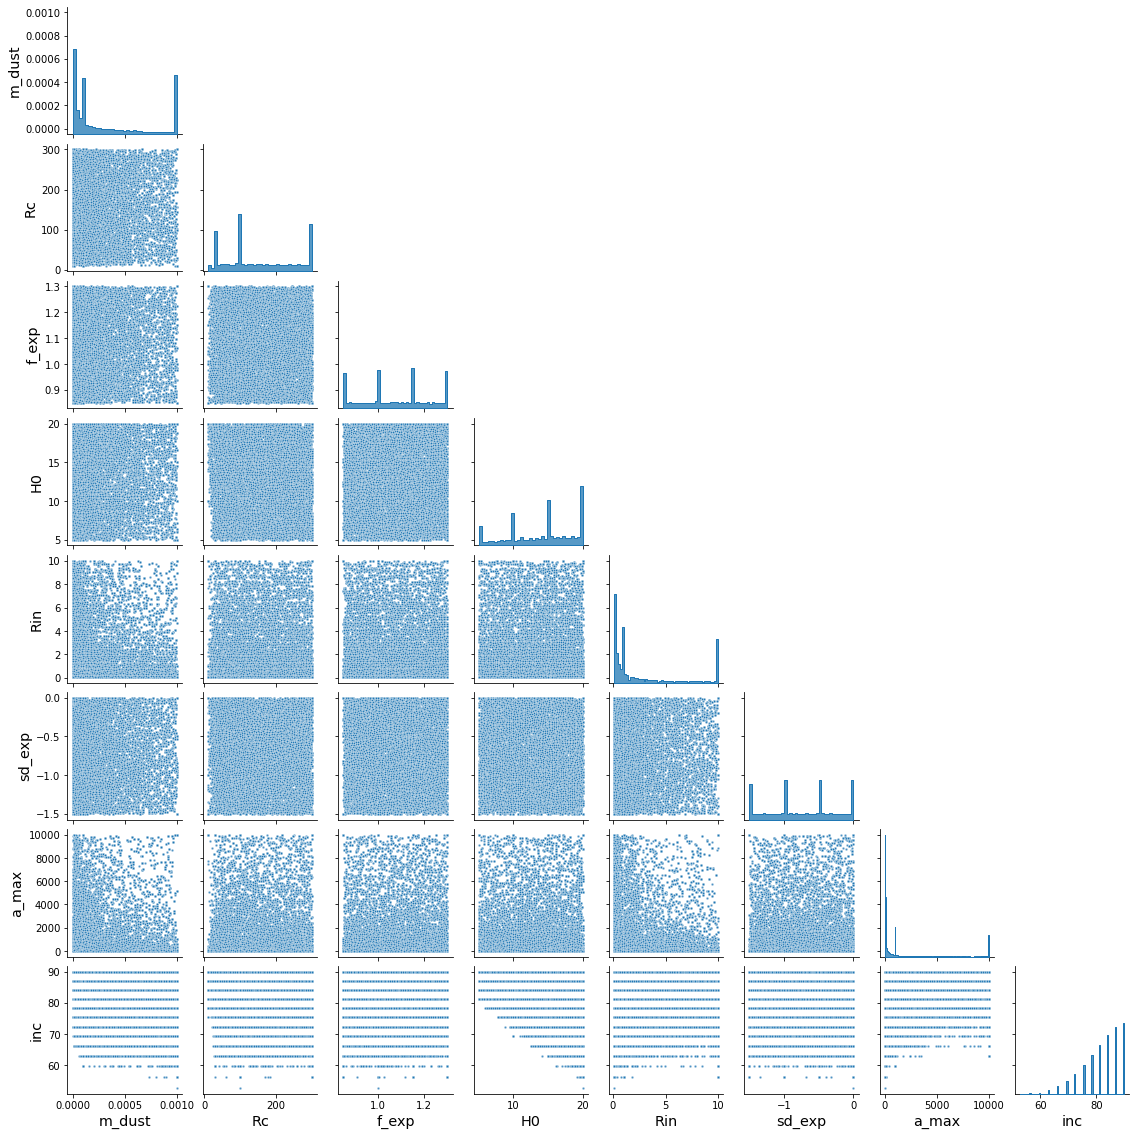

In [5]:
g = sb.pairplot(meta.sample(50000), diag_kind='hist', markers='.',height=2,
                plot_kws=dict(s=25, edgecolors='face', alpha=.8),
                diag_kws=dict(element='step'))
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()

# Synthetic Images

In [7]:
imgs = np.load('%s/imgs/PPD/img_array_gridandfiller123.npy' % (exa_root))
imgs = np.expand_dims(imgs, axis=1)
imgs.shape

(99825, 1, 187, 187)

In [8]:
print('Min ', imgs.min(), 'Max ', imgs.max())
print('Mean ', imgs.mean(), 'Std ', imgs.std())

Min  0.0 Max  3.9602598e-15
Mean  5.0852046e-20 Std  1.6909212e-18


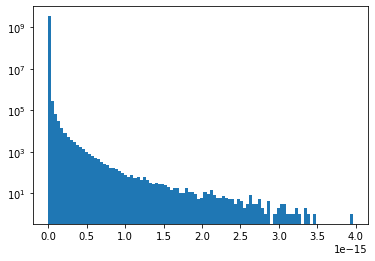

In [9]:
plt.hist(imgs.flatten(), bins=100, log=True)
plt.show()

In [42]:
def normalize(x, mode='global'):
    if mode == 'global':
        xmin = x.min()
        xmax = x.max()
        xn = (x - xmin) / (xmax - xmin)
        return xn, xmin, xmax
    elif mode == 'local':
        xmin = imgs.reshape(
            imgs.shape[0], np.product(
                imgs.shape[1:])).min(axis=1)[:, None, None, None]
        xmax = imgs.reshape(
            imgs.shape[0], np.product(
                imgs.shape[1:])).max(axis=1)[:, None, None, None]
        xn = (x - xmin) / (xmax - xmin)
        return xn, xmin, xmax
    else:
        print('Wrong mode')

In [45]:
imgs_n, nmin, nmax = normalize(imgs, mode='local')

In [54]:
nmax

array([[[[5.9015464e-16]]],


       [[[1.8756863e-16]]],


       [[[9.2780919e-17]]],


       ...,


       [[[4.4785361e-24]]],


       [[[1.2202321e-24]]],


       [[[4.5186983e-25]]]], dtype=float32)

In [46]:
print('Min ', imgs_n.min(), 'Max ', imgs_n.max())
print('Mean ', imgs_n.mean(), 'Std ', imgs_n.std())

Min  0.0 Max  1.0
Mean  0.006054175 Std  0.046657227


In [63]:
def plot_wall(x):
    """Light-curves wall plot, function used during VAE training phase.
    Figure designed and ready to be appended to W&B logger.

    Parameters
    ----------
    xhat : numpy array
        Array of generated light curves
    x    : numpy array
        List of real light curves.
    epoch: int, optional
        Epoch number

    Returns
    -------
    fig
        a matplotlib figure
    image
        an image version of the figure
    """

    plt.close('all')
    ncols = 10
    v_min = np.min(x)
    v_max = np.max(x)
    norm = colors.SymLogNorm(linthresh=1e-5, linscale=100,
                             vmin=v_min, vmax=v_max)
    print(v_min, v_max)
    fig, axis = plt.subplots(nrows=ncols, ncols=ncols, figsize=(ncols, ncols))
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(x[i, 0, :, :], interpolation='bilinear',
                  cmap=cm.viridis, origin='upper', aspect='equal',)
                  #norm=norm)

    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)#, left=0, right=1)
    #plt.tight_layout()
    #fig.suptitle('Synthetic Images', fontsize=20, y=.95)
    plt.show()
    return

0.0 1.0
0.0 1.0


<ipython-input-49-5ccbb3fa0760>:27: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=1e-5, linscale=100,


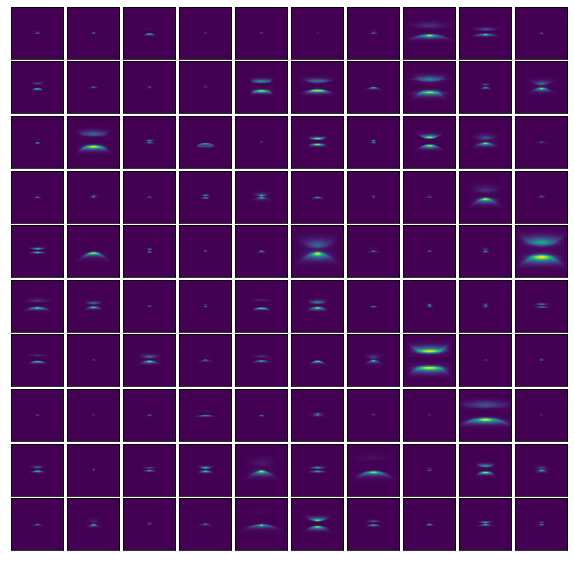

In [50]:
idx = np.random.randint(0, imgs.shape[0], size=100)
plot_wall(imgs_n[idx])

In [16]:
meta.iloc[idx].describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.675903e-04,168.107010,1.071650,13.931998,1.978000,-0.832413,1325.617554,81.402679
std,3.334790e-04,88.574516,0.146871,4.300572,3.051033,0.468636,2435.094727,7.245243
min,1.000000e-06,10.000000,0.850000,5.000000,0.100000,-1.500000,10.000000,59.663586
25%,2.225000e-05,100.000000,0.956000,10.975000,0.200000,-1.239509,22.669625,78.344276
50%,1.000000e-04,159.549995,1.076000,14.450000,1.000000,-0.913897,100.000000,81.284813
75%,3.730000e-04,244.275002,1.174500,17.375000,1.525000,-0.492993,1003.180786,87.104897
max,1.000000e-03,300.000000,1.300000,20.000000,10.000000,0.000000,10000.000000,90.000000


In [17]:
big = meta.query('f_exp == 1.3 and m_dust == 0.001 and Rc == 300 and H0 == 10 and Rin == 1.0 and sd_exp == -1.5 and a_max == 100').index.values
print(meta.iloc[big].shape)
meta.iloc[big]

(6, 8)


,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
35556,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,75.372246
35557,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,78.344276
35558,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,81.284813
35559,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,84.202362
35560,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,87.104897
35561,0.001,300.0,1.3,10.0,1.0,-1.5,100.0,90.000000


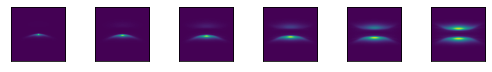

In [19]:
fig, axis = plt.subplots(nrows=1, ncols=6, figsize=(7, 1))
#norm = colors.SymLogNorm(linthresh=.0005, linscale=100, 
#                         vmin=v_min, vmax=v_max, base=10.)
for i, ax in enumerate(axis.ravel()):
    ax.imshow(imgs[big[i], 0, :, :], interpolation='bilinear',
              cmap=cm.viridis, origin='upper', aspect='equal')
for ax in axis.ravel():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.show()

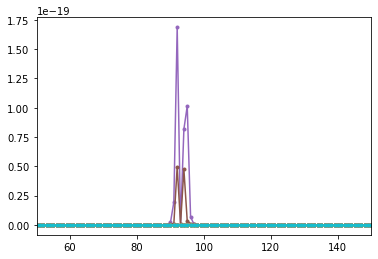

In [55]:
for k in range(50, 150, 10):
    plt.plot(imgs[36,0,:,k], '.-')
plt.xlim(50, 150)
plt.show()


## Filter by flaring exponent

In [60]:
f1_idx = meta.query('f_exp >= 1.').index.values
meta_f1 = meta.iloc[f1_idx]
imgs_f1 = imgs[f1_idx]
imgs_n_f1 = imgs_n[f1_idx]
meta_f1.shape, imgs_f1.shape, imgs_n_f1.shape

((70630, 8), (70630, 1, 187, 187), (70630, 1, 187, 187))

<ipython-input-63-48b7d52caedf>:26: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=1e-5, linscale=100,


0.0 1.0


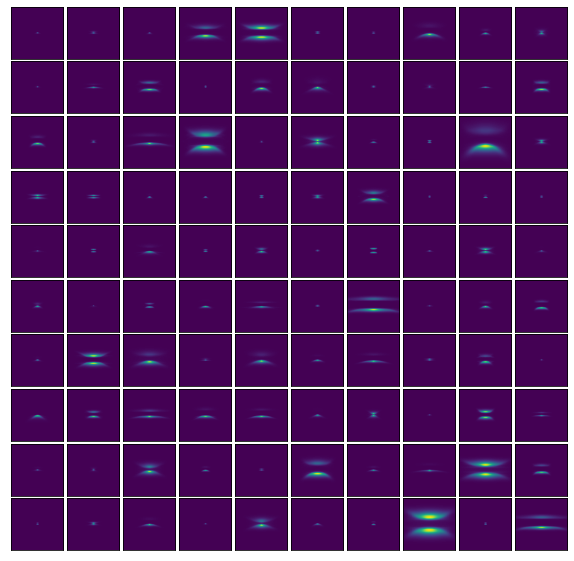

In [65]:
idx = np.random.randint(0, imgs_n_f1.shape[0], size=100)
plot_wall(imgs_n_f1[idx])

# Train / Val / Test splits

In [56]:
from sklearn.model_selection import train_test_split

In [66]:
train_idx, test_idx = train_test_split(np.arange(meta_f1.shape[0]), 
                                       test_size=.2, random_state=99)
train_idx.shape, test_idx.shape

((56504,), (14126,))

In [67]:
np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_fexp1_train_all.npy' % 
        (exa_root), meta_f1.iloc[train_idx].values.astype(np.float32))
np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_fexp1_test.npy' % 
        (exa_root), meta_f1.iloc[test_idx].values.astype(np.float32))

np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_imagenorm_fexp1_train_all.npy' % 
        (exa_root), imgs_n_f1[train_idx])
np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_imagenorm_fexp1_test.npy' % 
        (exa_root), imgs_n_f1[test_idx])

# Separate images by batches

In [68]:
n_batches = 5
batch_lims = np.linspace(0, train_idx.shape[0], n_batches+1, dtype=int)
print(batch_lims)

[    0 11300 22601 33902 45203 56504]


In [69]:
train_imgs = imgs_f1[train_idx]
train_pars = meta_f1.iloc[train_idx].values.astype(np.float32)

In [70]:
counter = 0
for k in range(n_batches):
    print([batch_lims[k] , batch_lims[k+1]])
    aux_img = train_imgs[batch_lims[k] : batch_lims[k+1]]
    aux_par = train_pars[batch_lims[k] : batch_lims[k+1]]
    print(aux_par.shape)
    counter += aux_par.shape[0]
    
    np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_fexp1_train_%i.npy' % 
        (exa_root, k+1), aux_par)
    np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_imagenorm_fexp1_train_%i.npy' % 
        (exa_root, k+1), aux_img)
    print('-----------------------')
    
print(counter)

[0, 11300]
(11300, 8)
-----------------------
[11300, 22601]
(11301, 8)
-----------------------
[22601, 33902]
(11301, 8)
-----------------------
[33902, 45203]
(11301, 8)
-----------------------
[45203, 56504]
(11301, 8)
-----------------------
56504


In [31]:
'_'+ 'f1'

'_f1'